In [1]:
%%capture
%matplotlib inline

# Downloads and imports


!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install ogb
!git clone https://github.com/m-k-S/neural-mechanics-geometric.git

import torch
import torch.nn as nn
import torch.nn.functional as F

from ogb.graphproppred import PygGraphPropPredDataset
from torch.utils.data import random_split
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures

import networkx as nx
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [9]:
# Hacky but convenient
# Re-run upon code changes to the utilities code (for cleanliness/conciseness)
!cd neural-mechanics-geometric/ && git pull

import sys
sys.path.append('./neural-mechanics-geometric')

from importlib import reload
import order_parameters, data_utils, train, model, data
reload(order_parameters)
reload(data_utils)
reload(train)
reload(model)
reload(data)

from order_parameters import ActivationProbe, ConvolutionProbe
from train import test_classification, train_classification, test_regression, train_regression
from data_utils import initial_order_params, save_order_params, clear_order_params
from model import NodeNet

remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/m-k-S/neural-mechanics-geometric
   c9ed02d..3c99f2f  master     -> origin/master
Updating c9ed02d..3c99f2f
Fast-forward
 data_utils.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [15]:
### DATASET LOADING ###
dataset = 'Cora'
task = 'classification'

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
train_loader = DataLoader(dataset, batch_size=1)

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
# print(f'Dataset balance: {dataset.data.y.flatten().bincount()[0] / len(dataset.data.y)}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [16]:
### INITIAL ORDER PARAMETERS ### 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_channels = 16
depths = torch.arange(2, 35, 8)

metrics = []

# Loop for getting initial activation and gradient norms (for a full training epoch, i.e. over all samples)

# Iterate over different normalization types
# norms = [None, 'BatchNorm', 'GraphNorm', 'PairNorm', 'DiffGroupNorm']

norms = [None, 'BatchNorm']
for norm_setting in tqdm(norms, desc="Normalization Types", position=0):

    # Iterate over different model depths
    for depth in tqdm(depths, desc="Network Depths", position=1, leave=False):

        if norm_setting == 'BatchNorm' or norm_setting == 'GraphNorm':
            norm_args = {'in_channels': hidden_channels}
        else:
            norm_args = None

        # Define model, optimizer, and loss
        model = NodeNet(
            hidden_channels=hidden_channels, 
            num_input_features = dataset[0].x.shape[-1],
            num_classes=dataset.num_classes,
            num_layers=depth, 
            conv_type="GCN",
            norm=norm_setting, 
            norm_args=norm_args
        ).to(device)            

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        # The mean of the initial activations and gradients are saved in these dictionaries; the keys are the corresponding layers
        m = initial_order_params(model, train_loader, criterion, optimizer, device)
        metrics += m

Normalization Types:   0%|          | 0/2 [00:00<?, ?it/s]

Network Depths:   0%|          | 0/5 [00:00<?, ?it/s]

Network Depths:   0%|          | 0/5 [00:00<?, ?it/s]

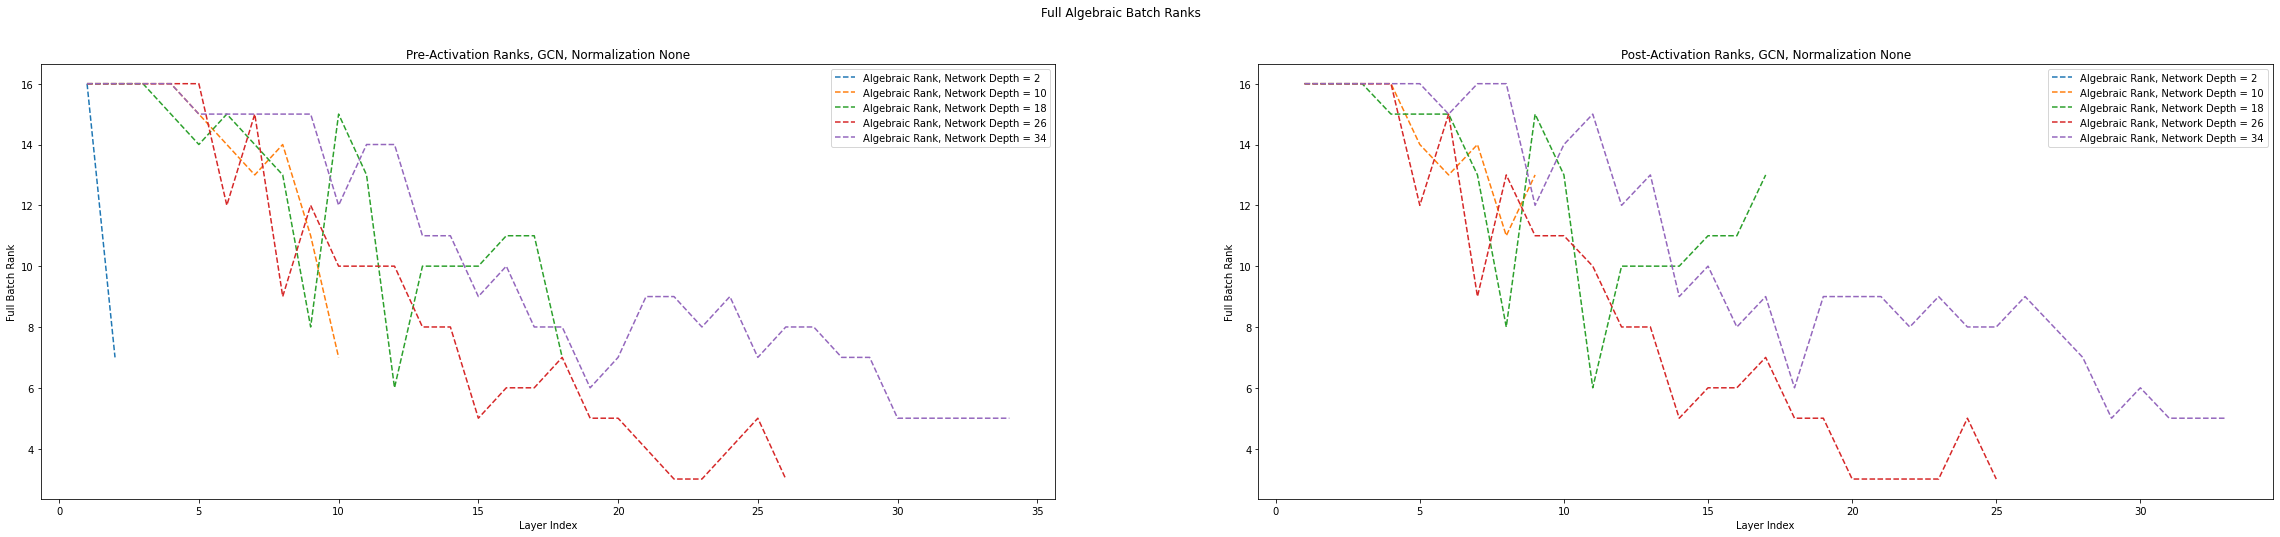

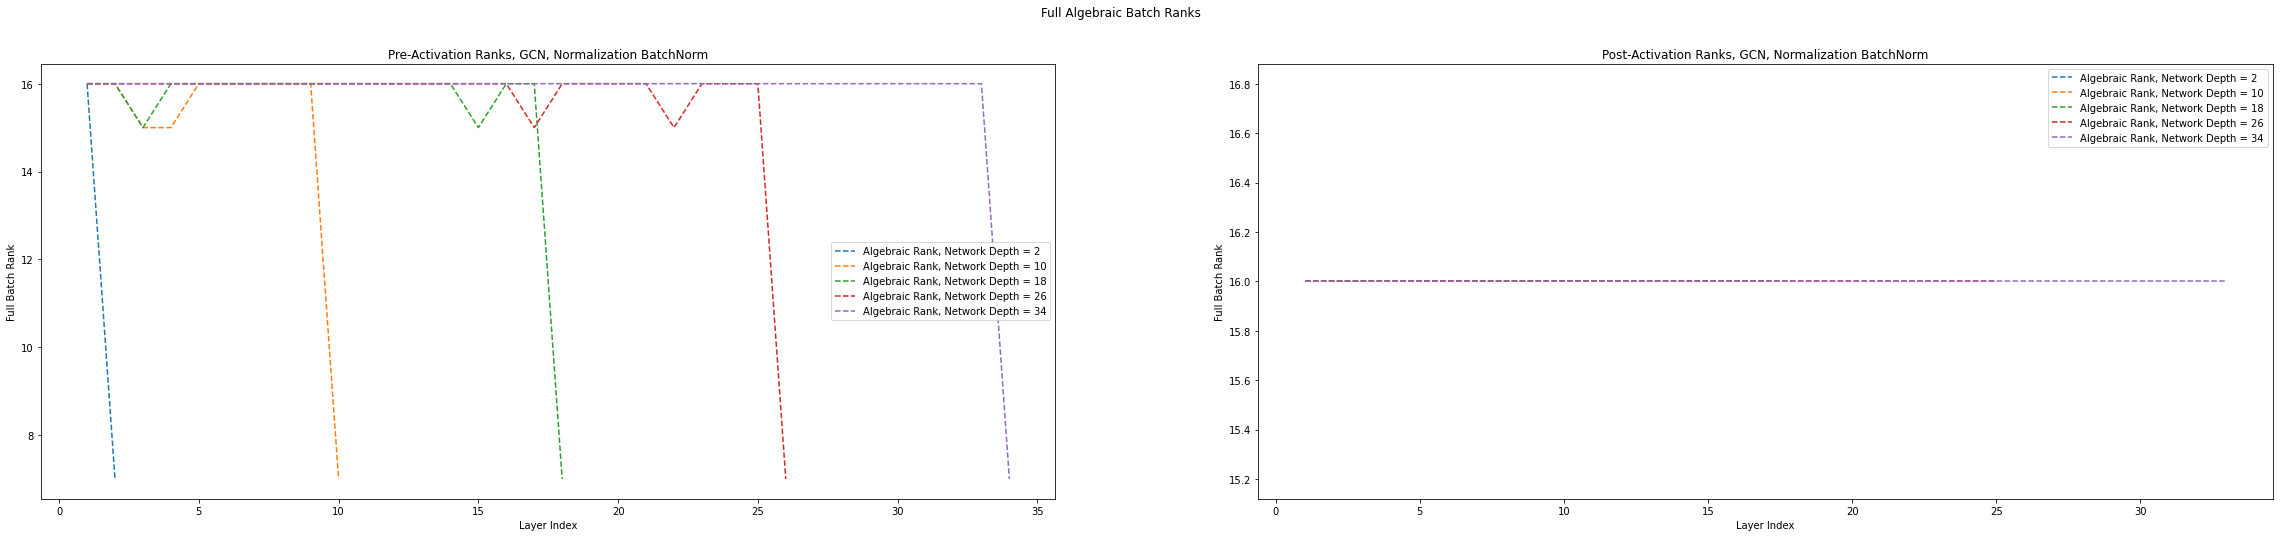

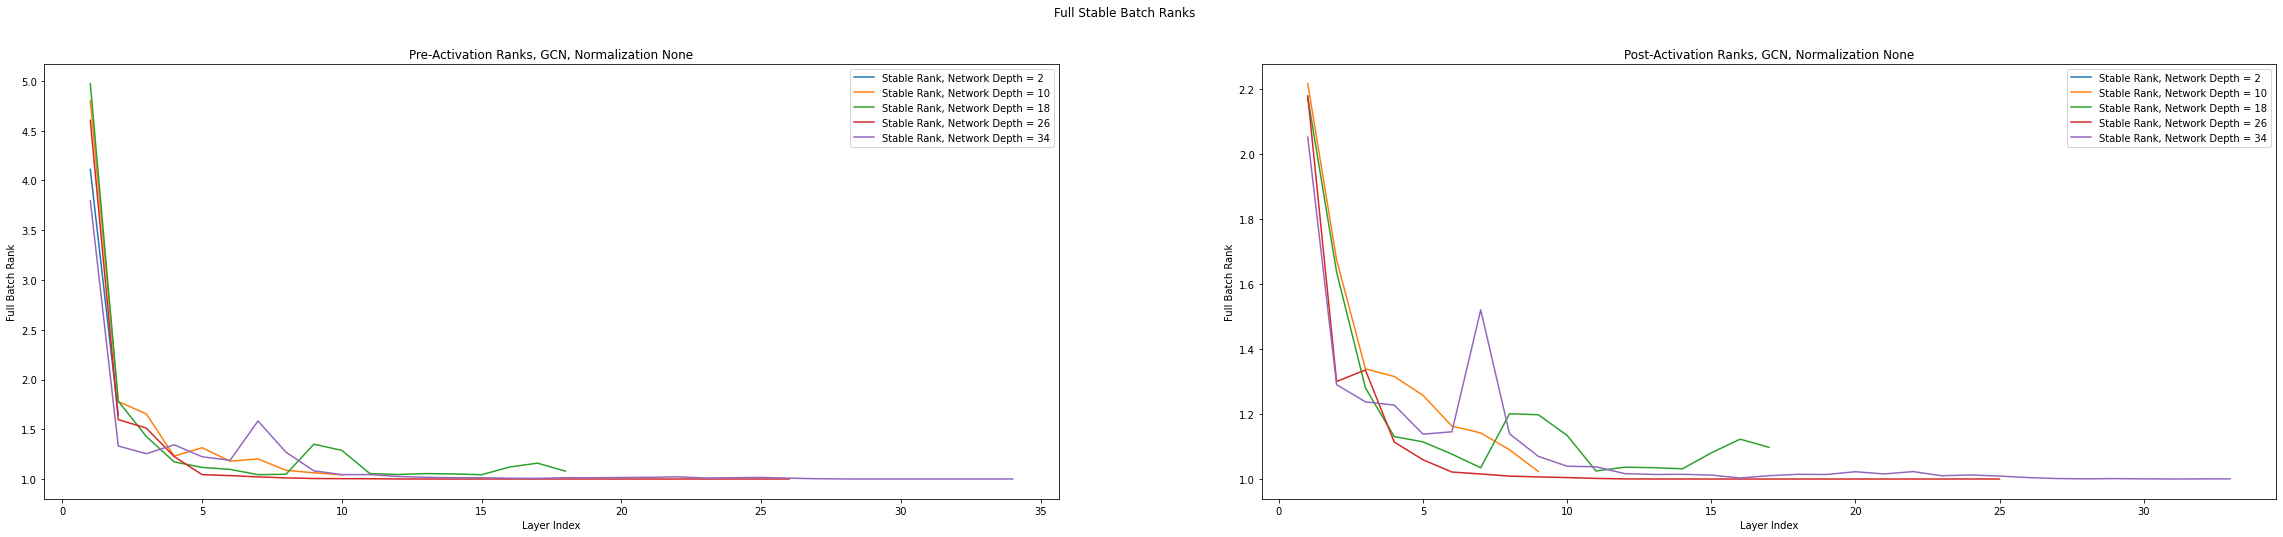

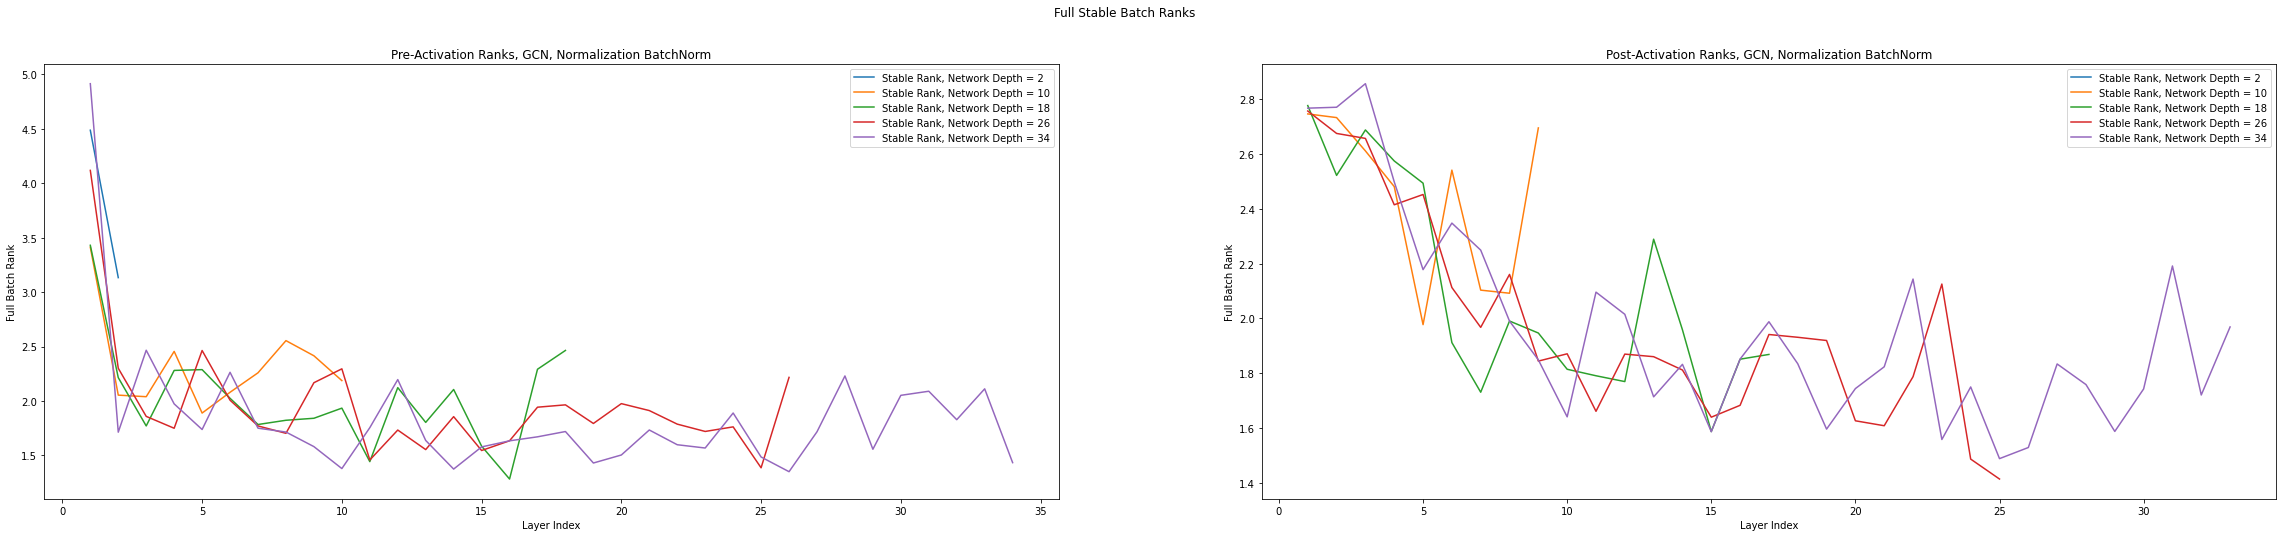

In [17]:
conv = "GCN"

for norm in ['None', 'BatchNorm']:
    layers = torch.arange(1, 49)
    conv_alg_ranks = {d.item(): [np.nan for l in layers] for d in depths}
    activ_alg_ranks = {d.item(): [np.nan for l in layers] for d in depths}

    for m in metrics:
        if m.layer_type=='Activation' and m.normalization==norm and m.conv_type == conv:
            if m.name == 'batch_algebraic_ranks':
                activ_alg_ranks[m.depth.item()][m.layer_index] = m.value

        if m.layer_type=='Convolution' and m.normalization==norm and m.conv_type == conv:
            if m.name == 'batch_algebraic_ranks':
                conv_alg_ranks[m.depth.item()][m.layer_index] = m.value

        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 8))
    fig.suptitle('Full Algebraic Batch Ranks')
    ax1.set_title("Pre-Activation Ranks, {}, Normalization {}".format(conv, norm))
    ax1.set_xlabel("Layer Index")
    ax1.set_ylabel("Full Batch Rank")
    for k,v in conv_alg_ranks.items():
        ax1.plot(layers, v, linestyle="--", label="Algebraic Rank, Network Depth = {}".format(k))
    ax1.legend()

    ax2.set_title("Post-Activation Ranks, {}, Normalization {}".format(conv, norm))
    ax2.set_xlabel("Layer Index")
    ax2.set_ylabel("Full Batch Rank")
    for k,v in activ_alg_ranks.items():
        ax2.plot(layers, v, linestyle="--", label="Algebraic Rank, Network Depth = {}".format(k))
    ax2.legend()
    plt.show()


for norm in ['None', 'BatchNorm']:
    layers = torch.arange(1, 49)
    conv_stable_ranks = {d.item(): [np.nan for l in layers] for d in depths}
    activ_stable_ranks = {d.item(): [np.nan for l in layers] for d in depths}

    for m in metrics:
        if m.layer_type=='Activation' and m.normalization==norm and m.conv_type == conv:
            if m.name == 'batch_stable_ranks':
                activ_stable_ranks[m.depth.item()][m.layer_index] = m.value

        if m.layer_type=='Convolution' and m.normalization==norm and m.conv_type == conv:
            if m.name == 'batch_stable_ranks':
                conv_stable_ranks[m.depth.item()][m.layer_index] = m.value
        
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 8))
    fig.suptitle('Full Stable Batch Ranks')
    ax1.set_title("Pre-Activation Ranks, {}, Normalization {}".format(conv, norm))
    ax1.set_xlabel("Layer Index")
    ax1.set_ylabel("Full Batch Rank")
    for k,v in conv_stable_ranks.items():
        ax1.plot(layers, v, linestyle="-", label="Stable Rank, Network Depth = {}".format(k))
    ax1.legend()

    ax2.set_title("Post-Activation Ranks, {}, Normalization {}".format(conv, norm))
    ax2.set_xlabel("Layer Index")
    ax2.set_ylabel("Full Batch Rank")
    for k,v in activ_stable_ranks.items():
        ax2.plot(layers, v, linestyle="-", label="Stable Rank, Network Depth = {}".format(k))
    ax2.legend()
    plt.show()

In [ ]:
initial_rank = []
initial_mean = []
initial_var = []
for d in train_loader:
    x = d.x.type(torch.FloatTensor)

    m = x.mean(dim=0)
    r = torch.linalg.matrix_rank(x)
    v = x.var(dim=0)
    initial_rank.append(r)
    initial_mean.append(m)
    initial_var.append(v)


initial_rank = sum(initial_rank) / len(initial_rank)
initial_mean = sum(initial_mean) / len(initial_mean)
initial_var = sum(initial_var) / len(initial_var)

print (initial_rank, initial_mean, initial_var)


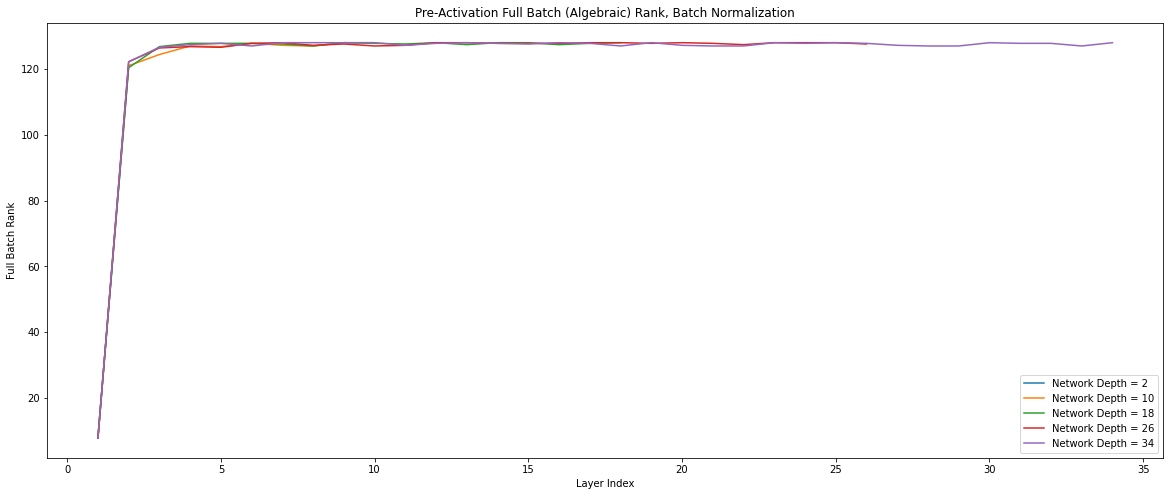

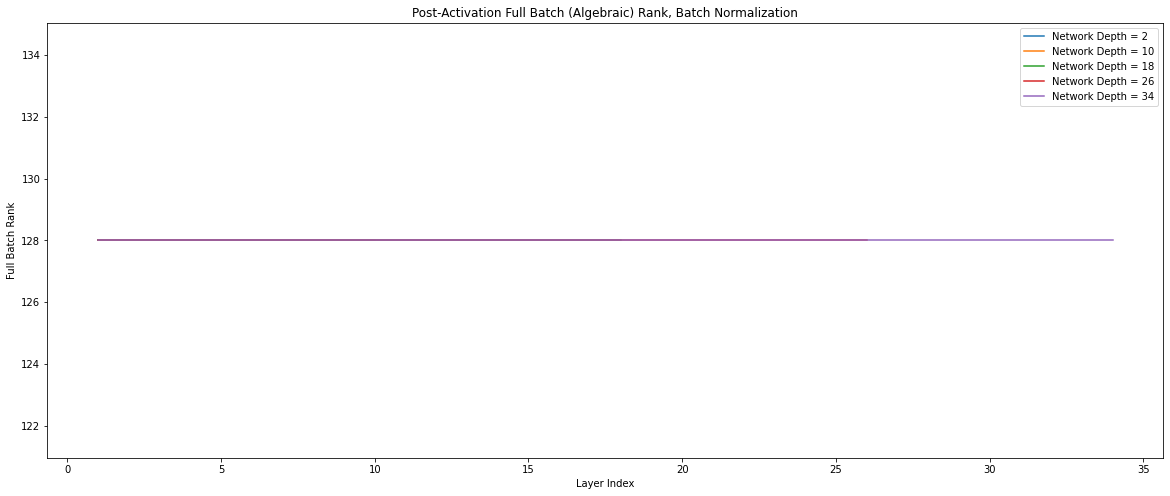

In [ ]:
# X AXIS - Layer index
# Y AXIS - Full batch rank
# LABELS - Varying network depths
# FIXED - Batch normalization

layers = torch.arange(1, 49)
conv_ranks = {d.item(): [np.nan for l in layers] for d in depths}
activ_ranks = {d.item(): [np.nan for l in layers] for d in depths}

for m in metrics:
    if m.layer_type=='Activation':
        if m.name=='batch_ranks':
            if m.normalization=="BatchNorm":
                activ_ranks[m.depth.item()][m.layer_index] = m.value
    if m.layer_type=='Convolution':
        if m.name=='batch_ranks':
            if m.normalization=="BatchNorm":
                conv_ranks[m.depth.item()][m.layer_index] = m.value
    

plt.figure(figsize=(20, 8))
plt.title("Pre-Activation Full Batch (Algebraic) Rank, Batch Normalization")
plt.xlabel("Layer Index")
plt.ylabel("Full Batch Rank")
for k,v in conv_ranks.items():
    plt.plot(layers, v, label="Network Depth = {}".format(k))
plt.legend()
plt.show()

plt.figure(figsize=(20, 8))
plt.title("Post-Activation Full Batch (Algebraic) Rank, Batch Normalization")
plt.xlabel("Layer Index")
plt.ylabel("Full Batch Rank")
for k,v in activ_ranks.items():
    plt.plot(layers, v, label="Network Depth = {}".format(k))
plt.legend()
plt.show()


tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36,
        38, 40, 42, 44, 46, 48])


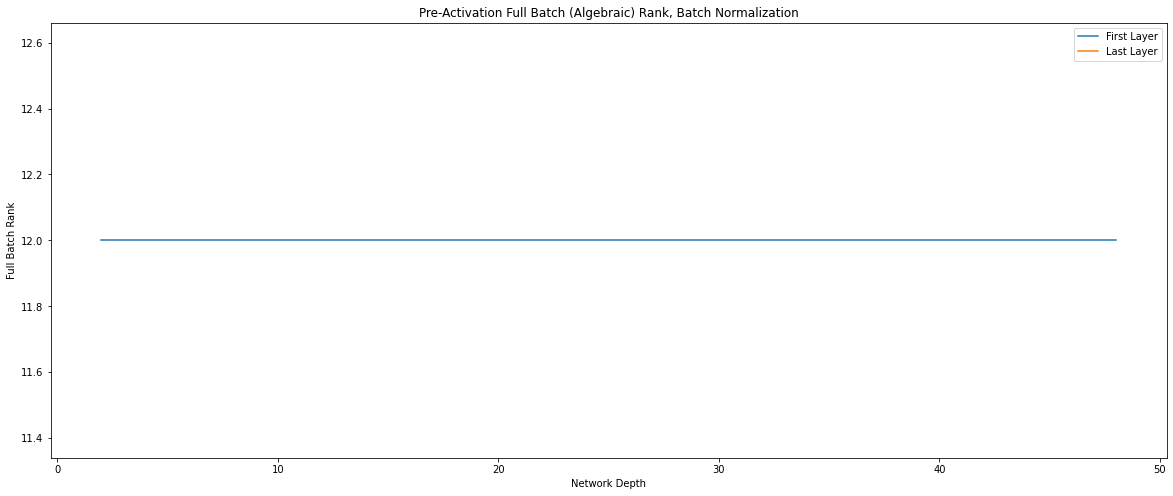

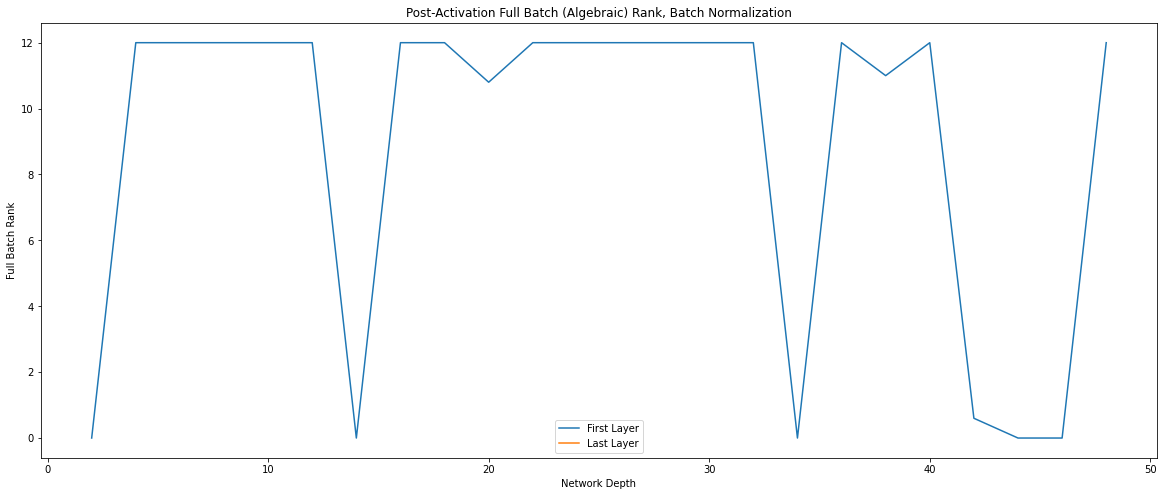

In [ ]:
# X AXIS - Network depth
# Y AXIS - Feature rank
# LABELS - First layer, last layer
# FIXED - Batch normalization, Feature 0

layers = torch.arange(1, 49)
conv_ranks = {'First Layer': [np.nan for _ in depths], 'Last Layer': [np.nan for _ in depths]}
activ_ranks = {'First Layer': [np.nan for _ in depths], 'Last Layer': [np.nan for _ in depths]}
print (depths)

for m in metrics:
    if m.layer_type=='Activation' and m.name=='feature_ranks' and m.feature == 0 and m.normalization=='None':
        depth_idx = (depths == m.depth.item()).nonzero(as_tuple=True)[0]
        if m.layer_index == 1:
            activ_ranks['First Layer'][depth_idx] = m.value
        if m.layer_index == m.depth.item():
            activ_ranks['Last Layer'][depth_idx] = m.value
    if m.layer_type=='Convolution' and m.name=='feature_ranks' and m.feature == 0 and m.normalization=='None':
        depth_idx = (depths == m.depth.item()).nonzero(as_tuple=True)[0]
        if m.layer_index == 1:
            conv_ranks['First Layer'][depth_idx] = m.value
        if m.layer_index == m.depth.item():
            conv_ranks['Last Layer'][depth_idx] = m.value
    

plt.figure(figsize=(20, 8))
plt.title("Pre-Activation Full Batch (Algebraic) Rank, Batch Normalization")
plt.xlabel("Network Depth")
plt.ylabel("Full Batch Rank")
for k,v in conv_ranks.items():
    plt.plot(depths, v, label=k)
plt.legend()
plt.show()

plt.figure(figsize=(20, 8))
plt.title("Post-Activation Full Batch (Algebraic) Rank, Batch Normalization")
plt.xlabel("Network Depth")
plt.ylabel("Full Batch Rank")
for k,v in activ_ranks.items():
    plt.plot(depths, v, label=k)
plt.legend()
plt.show()


In [ ]:
### TRAINING ###

epochs = 50
depths = torch.arange(3, 56, 12)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_channels = 128

metrics = []

# Training loop
# Iterate over different normalization types
# for norm_setting in [None, 'BatchNorm', 'GraphNorm', 'PairNorm']:
for norm_setting in tqdm([None, 'BatchNorm'], desc="Normalization Types", position=0):

    # Iterate over different model depths
    for depth in tqdm(depths, desc="Network Depth", position=1, leave=False):

        if norm_setting == 'BatchNorm' or norm_setting == 'GraphNorm':
                norm_args = {'in_channels': hidden_channels}
        else:
            norm_args = None

        # Define model, optimizer, and loss
        model = GCN(
            hidden_channels=hidden_channels, 
            num_input_features = dataset[0].x.shape[-1],
            num_layers=depth, 
            task=task, 
            norm=norm_setting, 
            norm_args=norm_args
        ).to(device)        
        criterion = torch.nn.MSELoss()

        for optimizer in tqdm([torch.optim.Adam(model.parameters(), lr=0.001), torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)], desc="Optimizer Type", position=2, leave=False):

            accuracies = {'test_acc': [], 'train_acc': []}

            # Training loop
            for epoch in tqdm(range(1, epochs+1), desc="Training Epoch", position=3, leave=False):
                train_regression(train_loader, model, criterion, optimizer, device)
                train_acc = test_regression(train_loader, model, criterion, device)
                test_acc = test_regression(test_loader, model, criterion, device)
                accuracies['test_acc'].append(test_acc)
                accuracies['train_acc'].append(train_acc)
                print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

            
            final_train_acc = TrainingMetric(
                depth=model.num_layers,
                normalization=str(model.norm),
                name="Training Accuracy",
                values=accuracies['train_acc'],
                optimizer=optimizer
            )
            final_test_acc = TrainingMetric(
                depth=model.num_layers,
                normalization=str(model.norm),
                name="Test Accuracy",
                values=accuracies['test_acc'],
                optimizer=optimizer
            )
            metrics.append(final_train_acc)
            metrics.append(final_test_acc)
            metrics += save_order_params(model, optimizer)
    

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Train Acc: 0.0113, Test Acc: 1.5193


KeyboardInterrupt: ignored

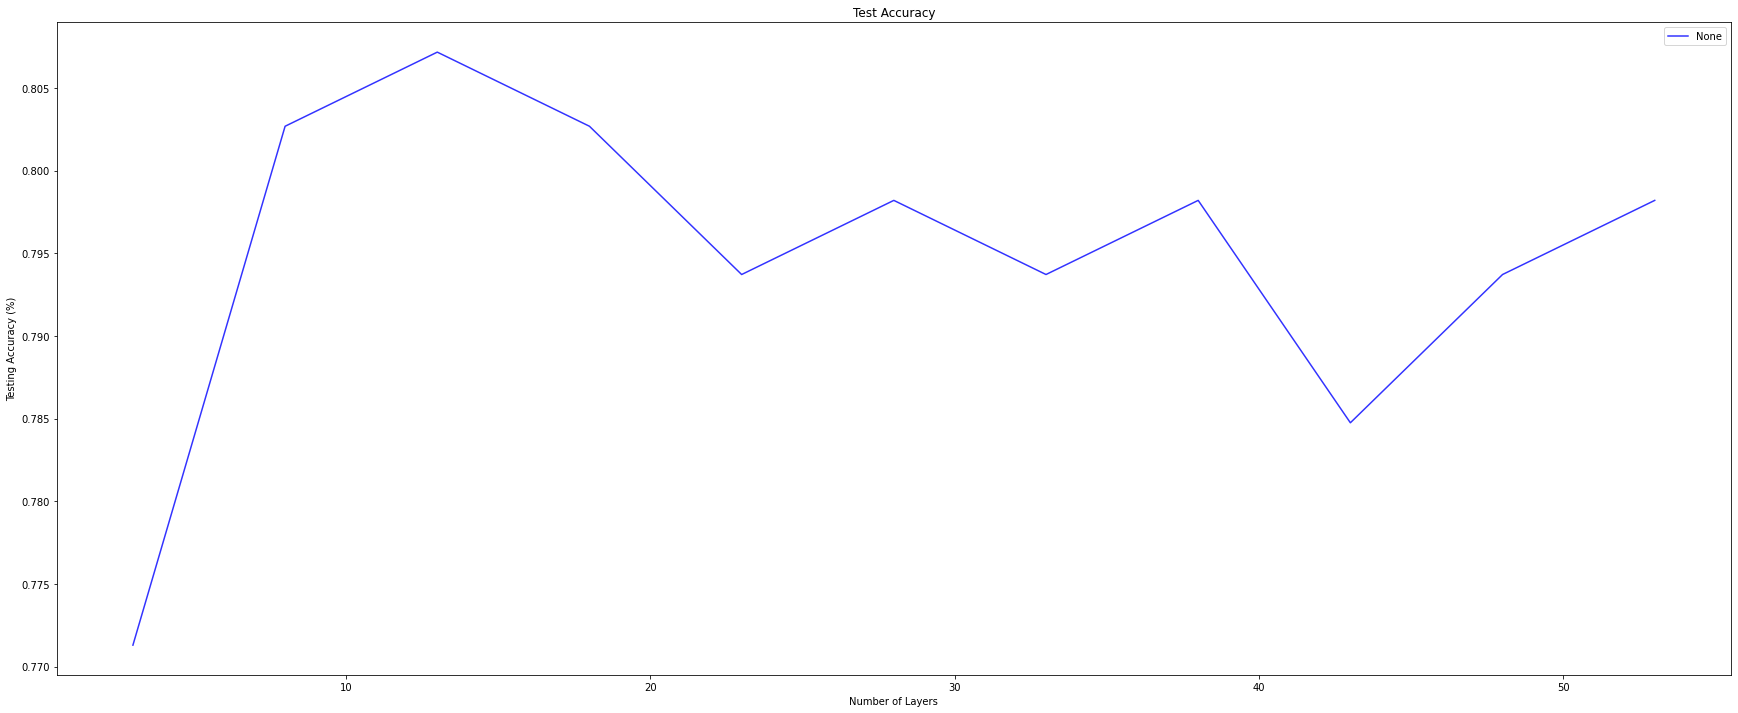

In [ ]:
# print (final_test_acc)

plt.figure(figsize=(30, 12))
plt.title('Test Accuracy')
plt.xlabel("Number of Layers")
plt.ylabel("Testing Accuracy (%)")

names = list(final_test_acc.keys())
norms = [n.split("_")[0] for n in names]
norms = [i for n, i in enumerate(norms) if i not in norms[:n]]

# for linestyle, norm in zip(['b', 'r', 'g', 'k'], norms):
for linestyle, norm in zip(['b'], norms):


    if norm != "DiffGroupNorm":

        Layer1 = []
        LayerF = []

        for depth in depths:

            depth = depth.item()

            Layer1.append(max(final_test_acc['{}_{}'.format(norm, depth)]))
            # LayerF.append(final_test_acc['{}_{}'.format(norm, depth)][depth-1])

        plt.plot(depths, Layer1, '{}-'.format(linestyle), markersize=3, alpha=0.8, label=norm)

        # plt.plot(depths, np.log10(LayerF), '{}s'.format(linestyle), markersize=3, alpha=0.3)


plt.legend()
plt.show()

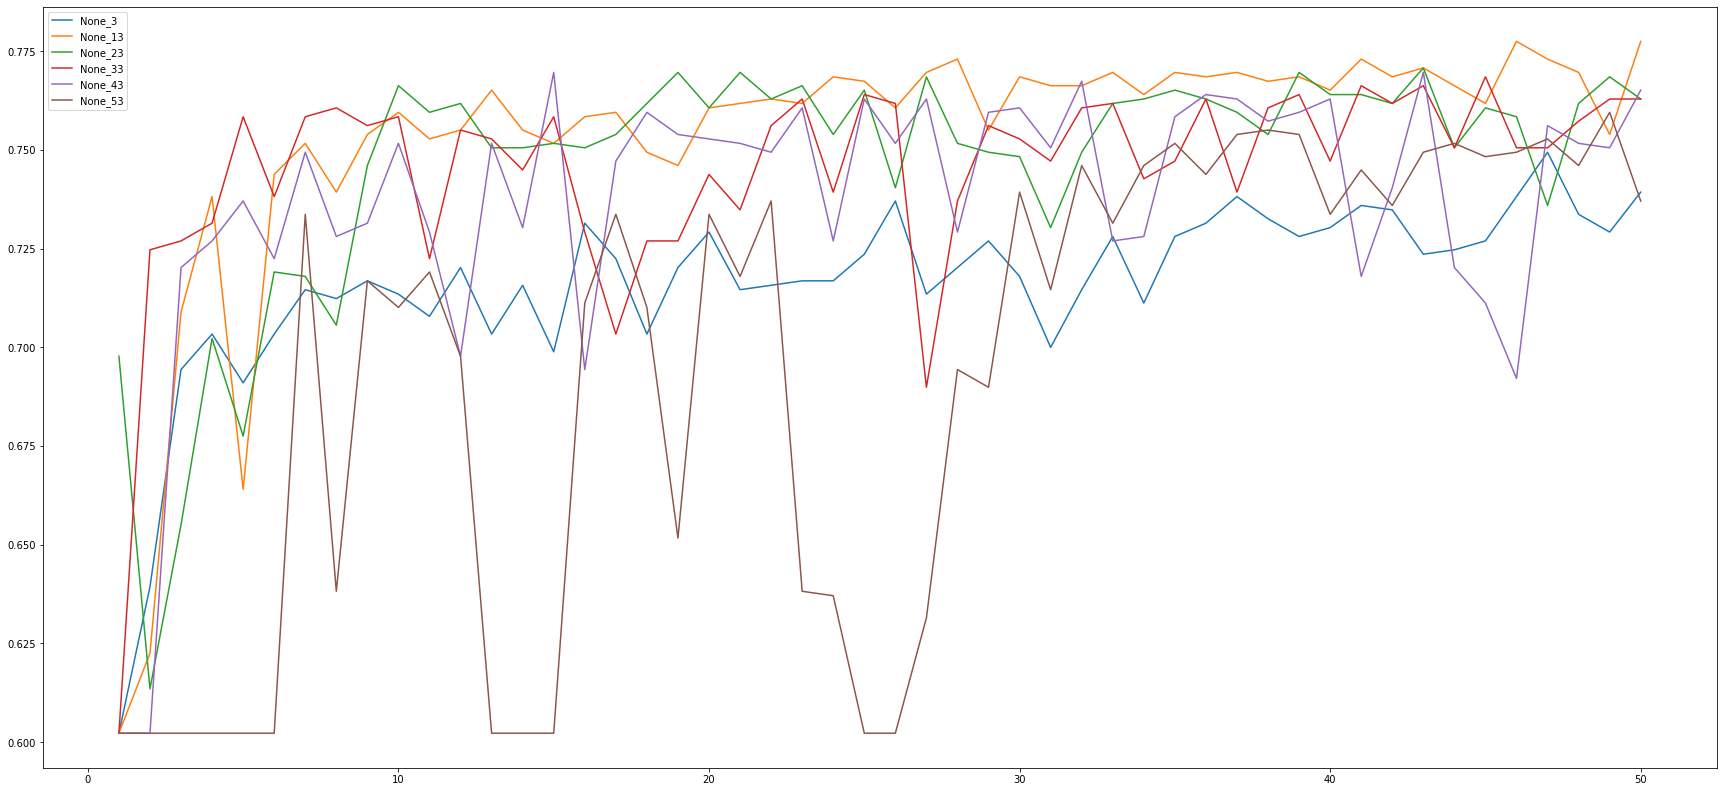

In [ ]:
plt.figure(figsize=(30, 14))
for idx, (k,v) in enumerate(final_train_acc.items()):
    if idx % 2 == 0:
        plt.plot([i for i in range(1, 51)], v, label=k)
plt.legend()
plt.show()

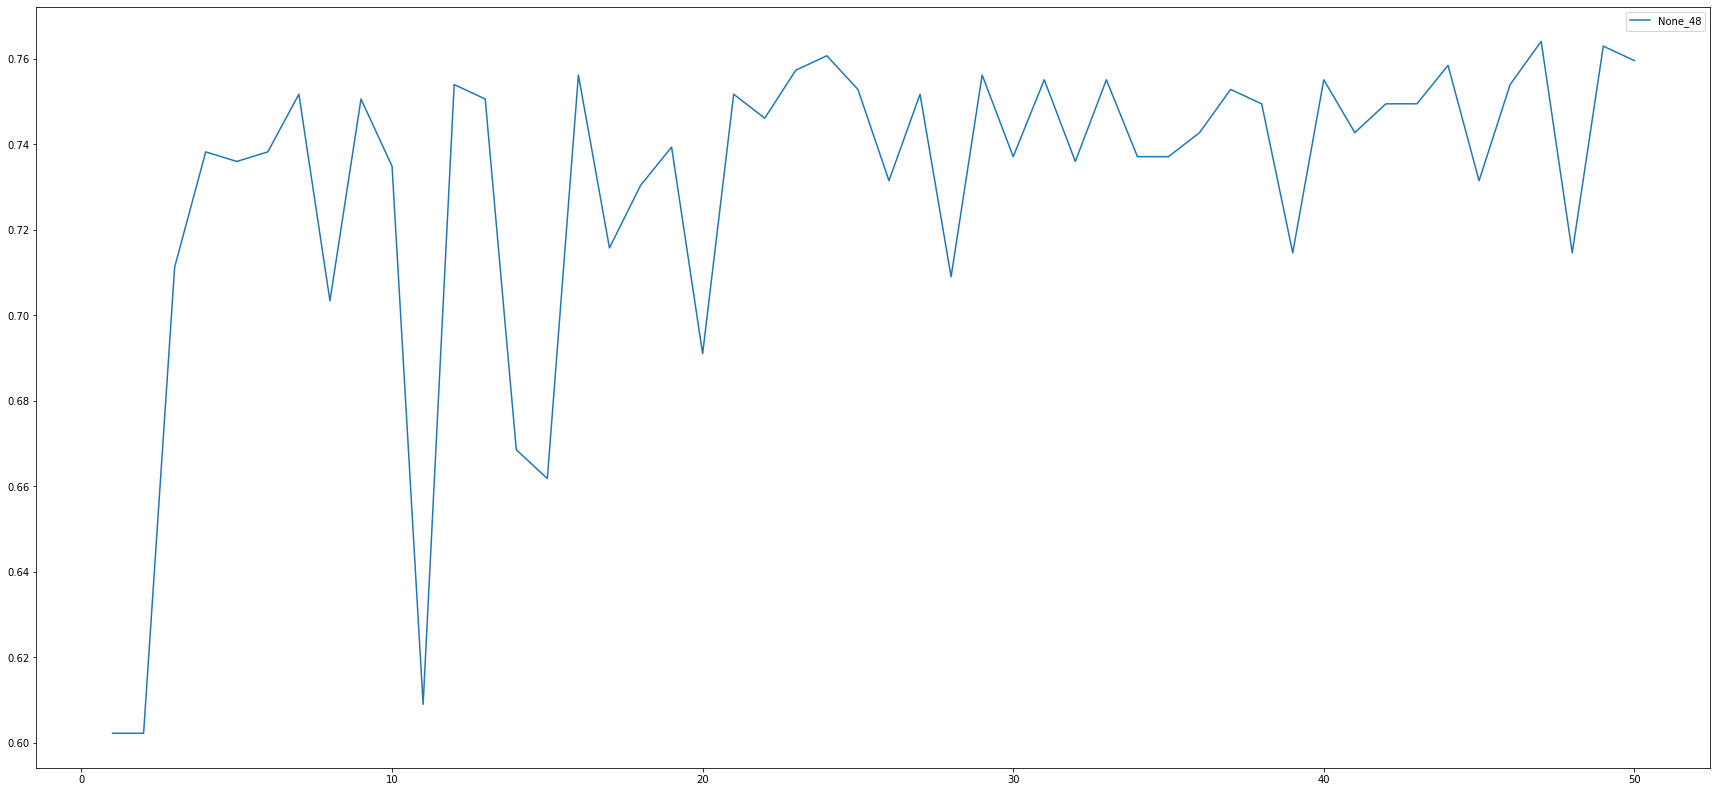

In [ ]:
plt.figure(figsize=(30, 14))
for idx, (k,v) in enumerate(final_train_acc.items()):
    if idx == 9:
        plt.plot([i for i in range(1, 51)], v, label=k)
plt.legend()
plt.show()